In [1]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)
import tensorflow as tf
from sklearn import preprocessing
import numpy as np
import random
import matplotlib.pyplot as plt
import sys
from  numba  import njit, prange
from Model.CNN import cnn_classifier
from utils.LoadData import load_CW_Target,load_CW_Source
from AES import *
from numba import njit
from tqdm import tqdm
from DANN_trainer import DANN
from utils.DANN_config import config

d:\VirtualEnvironment\Anaconda3\envs\TF-krease\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
d:\VirtualEnvironment\Anaconda3\envs\TF-krease\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
d:\VirtualEnvironment\Anaconda3\envs\TF-krease\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
d:\VirtualEnvironment\Anaconda3\envs\TF-krease\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
d:\VirtualEnvironment\Anaconda3\envs\TF-krease\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [7]:
@njit
def compute_attack_metrics(prediction_matrix, true_key_byte, plaintext_array, gf_mult, xor_const):
    """
    Compute Guessing Entropy and Success Rate for side-channel attacks
    
    Args:
        prediction_matrix: Model output probabilities [num_traces, num_classes]
        true_key_byte: Correct secret key value (0-255)
        plaintext_array: Array of plaintexts used in attacks
        gf_mult: GF(2^8) multiplication coefficient
        xor_const: XOR constant used in final step
    
    Returns:
        Tuple: (mean_guessing_entropy, success_rate_vector)
    """
    # Experiment configuration
    num_experiments = 20
    max_attack_traces = 3000
    guess_entropy_matrix = np.zeros((num_experiments, max_attack_traces), dtype=np.float64)
    success_matrix = np.zeros((num_experiments, max_attack_traces), dtype=np.float64)

    for experiment in range(num_experiments):
        # Random trace selection
        shuffled_indices = np.random.permutation(np.arange(plaintext_array.shape[0]))
        selected_indices = shuffled_indices[:max_attack_traces]

        # Initialize key hypothesis scoring
        key_scores = np.zeros((max_attack_traces, 256), dtype=np.float64)
        
        # Evaluate all key candidates
        for key_hypothesis in range(256):
            for trace_idx in range(max_attack_traces):
                current_pt = plaintext_array[selected_indices[trace_idx]]
                
                # Cryptographic operation simulation
                sbox_in = current_pt ^ key_hypothesis
                sbox_out = AES_Sbox[sbox_in]  # AES S-box substitution
                
                # GF(2^8) multiplication core
                gf_product = 0
                temp_gf = gf_mult
                for _ in range(8):
                    if sbox_out & 1:
                        gf_product ^= temp_gf
                    temp_gf = (temp_gf << 1) ^ (0x11B if (temp_gf & 0x80) else 0)
                    sbox_out >>= 1
                
                # Intermediate value calculation
                intermediate_val = gf_product ^ xor_const
                
                # Store prediction score
                key_scores[trace_idx, key_hypothesis] = prediction_matrix[
                    selected_indices[trace_idx], intermediate_val]

        # Numerical stability handling
        log_scores = np.log(key_scores + 1e-40)

        # Metrics computation
        for trace_count in range(max_attack_traces):
            cumulative_scores = np.sum(log_scores[:trace_count+1, :], axis=0)
            ranked_keys = np.argsort(cumulative_scores)[::-1]
            
            key_rank = np.where(ranked_keys == true_key_byte)[0][0]
            guess_entropy_matrix[experiment, trace_count] = key_rank
            success_matrix[experiment, trace_count] = (ranked_keys[0] == true_key_byte)

    # Aggregate results across experiments
    mean_ge = np.sum(guess_entropy_matrix, axis=0)/num_experiments
    success_rate = np.sum(success_matrix, axis=0)/num_experiments

    return mean_ge, success_rate

<b>Source Model-Source

In [3]:
# Main parameter initialization
profiling_Data_path='./Dataset/AES_OriginalMDS/'
model_save_path = './Model/'
model_name = 'Source_Model(Original MDS).h5'

In [4]:
# Load target dataset for attack analysis
(X_profiling, Y_profiling, X_test, Y_test, 
     plt_profiling, plt_test) = load_CW_Source(in_file=profiling_Data_path,sec=18000)



# 1. Standardization (Z-score normalization)
# Note: Should use scaler fitted on profiling set in real scenarios
standard_scaler = preprocessing.StandardScaler()
X_profiling = standard_scaler.fit_transform(X_profiling)  # Potential data leakage - for demo only
X_test = standard_scaler.transform(X_test)

# 2. Min-Max Scaling (Normalization to [0,1] range)
minmax_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
X_profiling = minmax_scaler.fit_transform(X_profiling)  # Demo purposes only
X_test = minmax_scaler.transform(X_test)

# 3. Reshape for CNN input: (num_samples, num_time_points, num_channels)
X_test_processed = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Initialize model architecture
model = cnn_classifier()  # Should match architecture used during training

# Load pre-trained weights
model.load_weights(model_save_path + model_name)


# Extract first byte of plaintext for byte-level analysis
plt_test_first_byte = plt_test[:, 0]

# Generate predictions using processed attack traces
predictions = model.predict(X_test_processed)


In [5]:
gf_multiplierA=2
Xor_constant=34

GE_Source, SR_Source=compute_attack_metrics(predictions, 0x3f, plt_test_first_byte,gf_multiplierA,Xor_constant)

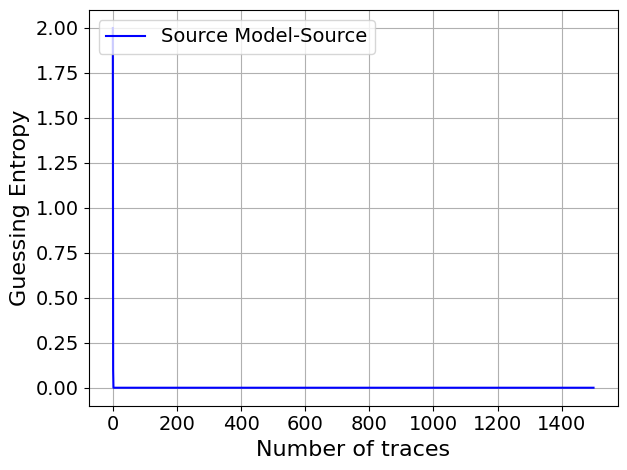

In [6]:
sec = 1500
x = np.arange(0, sec)
plt.plot(x, GE_Source[:sec],color='b',label='Source Model-Source')

plt.xlabel('Number of traces',fontsize=16)
plt.ylabel('Guessing Entropy',fontsize=16)
plt.tick_params(labelsize=14)
plt.legend(fontsize=14,loc="upper left")


plt.grid(True)  
plt.tight_layout()
plt.show()

<b>Source Model-Target(InvMDS)

In [7]:
# Main parameter initialization
profiling_Data_path='./Dataset/AES_OriginalMDS/'
Target_Data_path='./Dataset/AES_INVMDS/'
model_save_path = './Model/'
model_name = 'Source_Model(Original MDS).h5'

In [8]:
# Load target dataset for attack analysis
X_profiling, _, _, _, _, _ = load_CW_Source(
        in_file=profiling_Data_path,
        sec=18000,  # Fixed security parameter from original implementation
)

# in_file: Path to directory containing power traces and metadata
X_attack, raw_label, plt_attack = load_CW_Target(
        in_file=Target_Data_path,
)



# 1. Standardization (Z-score normalization)
# Note: Should use scaler fitted on profiling set in real scenarios
standard_scaler = preprocessing.StandardScaler()
X_profiling = standard_scaler.fit_transform(X_profiling)  # Potential data leakage - for demo only
X_attack = standard_scaler.transform(X_attack)

# 2. Min-Max Scaling (Normalization to [0,1] range)
minmax_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
X_profiling = minmax_scaler.fit_transform(X_profiling)  # Demo purposes only
X_attack = minmax_scaler.transform(X_attack)

# 3. Reshape for CNN input: (num_samples, num_time_points, num_channels)
X_attack_processed = X_attack.reshape((X_attack.shape[0], X_attack.shape[1], 1))

# Initialize model architecture
model = cnn_classifier()  # Should match architecture used during training

# Load pre-trained weights
model.load_weights(model_save_path + model_name)


# Extract first byte of plaintext for byte-level analysis
plt_attack_first_byte = plt_attack[:, 0]

# Generate predictions using processed attack traces
predictions = model.predict(X_attack_processed)


In [9]:
gf_multiplierA=0xe
Xor_constant=0x54

GE_Target_INVMDS, SR_Target_INVMDS=compute_attack_metrics(predictions, 0x3f, plt_attack_first_byte,gf_multiplierA,Xor_constant)
 

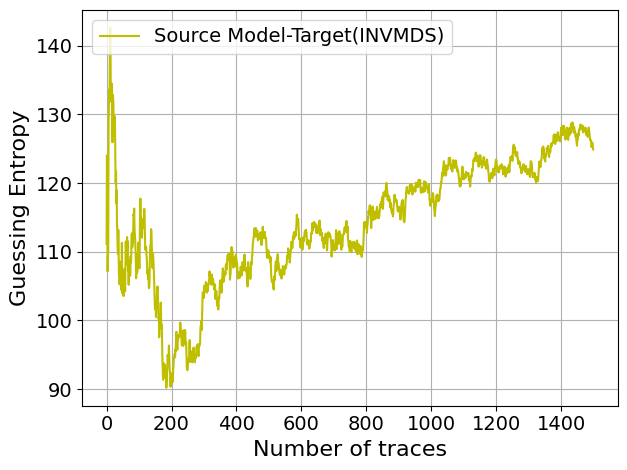

In [23]:
sec = 1500
x = np.arange(0, sec)
plt.plot(x, GE_Target_INVMDS[:sec],color='y',label='Source Model-Target(INVMDS)')

plt.xlabel('Number of traces',fontsize=16)
plt.ylabel('Guessing Entropy',fontsize=16)
plt.tick_params(labelsize=14)
plt.legend(fontsize=14,loc="upper left")


plt.grid(True)  
plt.tight_layout()
plt.show()

<b>Transfer Model-Target(InvMDS)

In [3]:
# Main parameter initialization
profiling_Data_path='./Dataset/AES_OriginalMDS/'
Target_Data_path='./Dataset/AES_INVMDS/'
model_save_path = './Model/'
model_name='Transfer_Model(Original MDS).h5'

In [5]:
# Load target dataset for attack analysis
X_profiling, _, _, _, _, _ = load_CW_Source(
        in_file=profiling_Data_path,
        sec=18000,  # Fixed security parameter from original implementation
)

# in_file: Path to directory containing power traces and metadata
X_attack, raw_label, plt_attack = load_CW_Target(
        in_file=Target_Data_path,
)



# 1. Standardization (Z-score normalization)
# Note: Should use scaler fitted on profiling set in real scenarios
standard_scaler = preprocessing.StandardScaler()
X_profiling = standard_scaler.fit_transform(X_profiling)  # Potential data leakage - for demo only
X_attack = standard_scaler.transform(X_attack)

# 2. Min-Max Scaling (Normalization to [0,1] range)
minmax_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
X_profiling = minmax_scaler.fit_transform(X_profiling)  # Demo purposes only
X_attack = minmax_scaler.transform(X_attack)

# 3. Reshape for CNN input: (num_samples, num_time_points, num_channels)
X_attack_processed = X_attack.reshape((X_attack.shape[0], X_attack.shape[1], 1))

# Initialize model architecture
cfg = config(pre_model_path=model_save_path + model_name)
dann = DANN(cfg)  

# Extract first byte of plaintext for byte-level analysis
plt_attack_first_byte = plt_attack[:, 0]

# Generate predictions using processed attack traces
predictions, domain = dann.dann_model(X_attack)



In [8]:
gf_multiplierA=0xe
Xor_constant=0x54

GE_Transfer_INVMDS, SR_Transfer_INVMDS=compute_attack_metrics(predictions, 0x3f, plt_attack_first_byte,gf_multiplierA,Xor_constant)
 

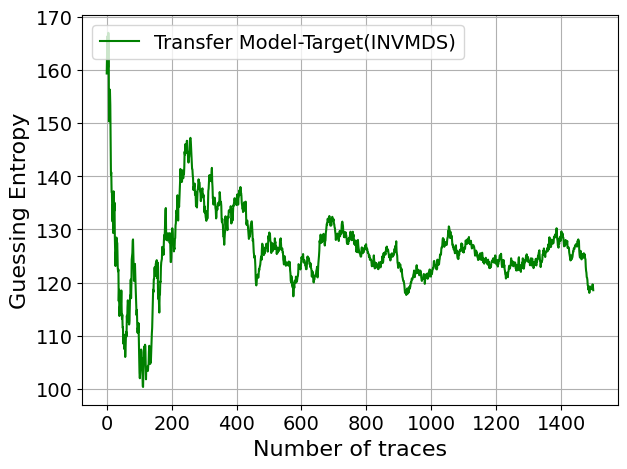

In [10]:
sec = 1500
x = np.arange(0, sec)
plt.plot(x, GE_Transfer_INVMDS[:sec],color='g',label='Transfer Model-Target(INVMDS)')

plt.xlabel('Number of traces',fontsize=16)
plt.ylabel('Guessing Entropy',fontsize=16)
plt.tick_params(labelsize=14)
plt.legend(fontsize=14,loc="upper left")


plt.grid(True)  # 显示网格
plt.tight_layout()
plt.show()